In [300]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
#import countryinfo as ci
from shapely.geometry import box
import cartopy

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


# Load the data
def load_data(path):
    df = pd.read_csv(path)
    return df

hantavirus = load_data('../data/ncbi_virus/hantaviridae_ncbi_03062025.csv')
arenavirus = load_data('../data/ncbi_virus/arenaviridae_ncbi_03062025.csv')

#Lists of location types for ArHa
city_terms = [
    'city', 'municipality', 'town', 'rural locality', 'port', 'urban locality', 'village',
    'locality', 'VerbatimLocality', 'trap line', 'East of Town', 'Island Capital', 'Town', 
    'City', 'Reported Site', 'Estimated Locality', 'region Center', 'Given Site', 
    'Given Location', 'Estimated locality', 'Average Locality'
]

state_terms = [
    'state', 'province', 'region', 'district', 'county', 'county region', 'oblast', 
    'department', 'prefecture', 'banner', 'statistical region', 'ceremonial county',
    'Average District', 'State', 'Province', 'Region', 'County', 'Average of County coordinates',
    'South Western Hungary', 'Central Argentina'
]

sampling_site_terms = [
    'site', 'trap', 'sampling sites', 'preserve', 'nature reserve', 'national park', 
    'national reserve', 'national wildlife refuge', 'state park', 'forest', 'military training area',
    'land type', 'management area', 'trap line', 'River Delta', 'river', 'lake', 'mountain',
    'area', 'Sites', 'National Reserve', 'Jabora Site', 'Average Location', 'Reported Site',
    'Stated Location', 'Given site', 'Given Site', 'Stated Area', 'Stated Coordinates'
]

In [301]:
#Explore the data
print(hantavirus.head())
print(arenavirus.head())

# Bind the data, but add a column to distinguish between the two
hantavirus['virus_type'] = 'hantavirus'
arenavirus['virus_type'] = 'arenavirus'

viruses_ncbi = pd.concat([hantavirus, arenavirus])
#Make column names lowercase to match column names in Arha
viruses_ncbi.columns = viruses_ncbi.columns.str.lower()

   Accession                  Organism_Name GenBank_RefSeq         Assembly  \
0  NC_077666    Orthohantavirus puumalaense         RefSeq  GCF_002829765.1   
1  NC_077667    Orthohantavirus puumalaense         RefSeq  GCF_002829765.1   
2  NC_077668    Orthohantavirus puumalaense         RefSeq  GCF_002829765.1   
3  NC_077669  Orthohantavirus sinnombreense         RefSeq  GCF_002830985.1   
4  NC_077670  Orthohantavirus sinnombreense         RefSeq  GCF_002830985.1   

  SRA_Accession                                         Submitters  \
0           NaN  Giebel,L.B., Stohwasser,R., Zoller,L., Bautz,E...   
1           NaN       Stohwasser,R., Raab,K., Darai,G., Bautz,E.K.   
2           NaN  Stohwasser,R., Giebel,L.B., Zoller,L., Bautz,E...   
3           NaN  Chizhikov,V.E., Spiropoulou,C.F., Morzunov,S.P...   
4           NaN  Chizhikov,V.E., Spiropoulou,C.F., Morzunov,S.P...   

                                        Organization Org_location  \
0  National Center for Biotechnolog

In [302]:
# Load the sequence data from ArHa.
arha = pd.read_csv('../data/raw_data/accession_number.csv', encoding='windows-1252')

#Check the formatting of the fasta accession
print(arha['accession_number'].head())
""" 
0    AJ269549 #No version number
1    AJ269550
2    AJ269551
3    AJ269552
4    AJ269553 
"""
#Some have version numbers, some don't. Remove the version numbers
def remove_version(data):
    data['accession_number'] = data['accession_number'].str.split('.').str[0]
    return data

arha = remove_version(arha)
#Keep only the accessions related to Pathogens
arha = arha[arha['sequenceType'] == 'Pathogen']

#Filter the NCBI data to only include the sequences that are in the ArHa data
arha_accession = arha['accession_number']
viruses_ncbi = viruses_ncbi[viruses_ncbi['accession'].isin(arha_accession)]

#save the data
#viruses_ncbi.to_csv('../data/ncbi_virus/viruses_ncbi.csv', index=False)
#arha.to_csv('../data/ncbi_virus/arha.csv', index=False)

#create a crosswalk dictionary
crosswalk = {'accession':'accession_number',
             'host':'species',
             'species':'virus_clean'
}

#change the names of viruses_ncbi columns to match the arha columns
viruses_ncbi.rename(columns=crosswalk, inplace=True)

0    AJ269549
1    AJ269550
2    AJ269551
3    AJ269552
4    AJ269553
Name: accession_number, dtype: object


In [303]:
import pandas as pd

# Filter the NCBI data to only include the sequences that are in the ArHa data
arha_accession = arha['accession_number']
viruses_ncbi_filtered = viruses_ncbi[viruses_ncbi['accession_number'].isin(arha_accession)]

# Set the index in each DataFrame to the common key (after aligning key names)
arha_indexed = arha.set_index('accession_number')
ncbi_indexed = viruses_ncbi_filtered.set_index('accession_number')

# Use combine_first to fill missing values in ArHa with those from NCBI
# This method takes the data from the left (arha_indexed) and, where values are missing,
# replaces them with corresponding non-null values from ncbi_indexed.
enriched_arha = arha_indexed.combine_first(ncbi_indexed)

# Reset the index so that 'accession_number' becomes a column again
enriched_arha = enriched_arha.reset_index()

# Optionally, save the enriched DataFrame to a new CSV file
#enriched_arha.to_csv('arha_enriched.csv', index=False)

print("Enrichment complete. 'arha_enriched.csv' has been created.")

Enrichment complete. 'arha_enriched.csv' has been created.


In [304]:
# Calculate the percentage of sequences that have NA in the "Country" column in the viruses_ncbi data
def percentage_na(data):
    na_country = data['country'].isna().sum()
    total = len(data)
    percentage = (na_country/total)*100
    return percentage

print(f"%NA: {round(percentage_na(viruses_ncbi),3)}")
print(f"%NA: {round(percentage_na(enriched_arha),3)}")

#Calculate the percentage that has location only at the country level
def percentage_country(data):
    country_only = data[data['country'] == data['geo_location']]
    number_country_only = len(country_only)
    total = len(data)
    percentage = (number_country_only / total) * 100
    return percentage

def percentage_country_arha(data):
    country_only = data['coordinate_resolution'] == 'country'
    number_country_only = len(data[country_only])
    total = len(data)
    percentage = (number_country_only / total) * 100
    return percentage

#calculate location statistics
def percentage_coordinates(data, col1, col2):
    coordinates = []
    for index, row in data.iterrows():
        if pd.notnull(row[col1]) and pd.notnull(row[col2]):
            coordinates.append(row[col1])
    number_coordinates = len(coordinates)
    total = len(data)
    percentage = (number_coordinates / total) * 100
    return percentage

def percentage_coordinates_ncbi(data):
    coordinates = []
    for index, row in data.iterrows():
        # Convert to string and check for ':'
        if isinstance(row['geo_location'], str) and ':' in row['geo_location']:
            coordinates.append(row['geo_location'])
    
    number_coordinates = len(coordinates)
    total = len(data)
    
    # Avoid division by zero
    percentage = (number_coordinates / total) * 100 if total > 0 else 0
    return percentage

def missing_host(data, col):
    """
    Calculate the percentage of missing values in a specified column.
    """
    missing = data[col].isna().sum()
    total = len(data)
    percentage = (missing / total) * 100 if total > 0 else 0  # Avoid division by zero
    return percentage

def percentage_city_arha(data):
    """
    Calculate the percentage of records that have a city-level coordinate resolution.
    """
    city = data['coordinate_resolution'].isin(city_terms)
    number_city = city.sum()  # Use sum() instead of len(data[city])
    total = len(data)
    percentage = (number_city / total) * 100 if total > 0 else 0
    return percentage

def percentage_state_arha(data):
    """
    Calculate the percentage of records that have a state-level coordinate resolution.
    """
    state = data['coordinate_resolution'].isin(state_terms)
    number_state = state.sum()  # Use sum() instead of len(data[state])
    total = len(data)
    percentage = (number_state / total) * 100 if total > 0 else 0
    return percentage

def percentage_sampling_site_arha(data):
    """
    Calculate the percentage of records that have a sampling site coordinate resolution.
    """
    sampling_site = data['coordinate_resolution'].isin(sampling_site_terms)
    number_sampling_site = sampling_site.sum()  # Use sum() instead of len(data[sampling_site])
    total = len(data)
    percentage = (number_sampling_site / total) * 100 if total > 0 else 0
    return percentage

def percentage_collection_date_missing(data, col):
    """
    Calculate the percentage of missing values in the collection_date column.
    """
    missing = data[col].isna().sum()
    total = len(data)
    percentage = (missing / total) * 100 if total > 0 else 0  # Avoid division by zero
    return percentage

def percentage_collection_date_month(data, col):
    """
    Calculate the percentage of records where collection_date consists of 7 characters ("yyyy-mm" or "yyyy/mm").
    """
    month_format = data[col].dropna().astype(str).str.len() == 7
    number_month = month_format.sum()
    total = len(data)
    percentage = (number_month / total) * 100 if total > 0 else 0
    return percentage

def percentage_collection_date_year(data, col):
    """
    Calculate the percentage of records where collection_date consists of:
    - 4 characters ("yyyy")
    - 9 characters ("yyyy-yyyy")
    """
    year_format = data[col].dropna().astype(str).str.len().isin([4, 9])
    number_year = year_format.sum()
    total = len(data)
    percentage = (number_year / total) * 100 if total > 0 else 0
    return percentage

def percentage_collection_date_day(data, col):
    """
    Calculate the percentage of records where collection_date consists of 10 characters 
    (e.g., "yyyy-mm-dd" or "yyyy/mm/dd").
    """
    day_format = data[col].dropna().astype(str).str.len() == 10
    number_day = day_format.sum()
    total = len(data)
    percentage = (number_day / total) * 100 if total > 0 else 0
    return percentage


print(f"%Country only: {round(percentage_country(viruses_ncbi),3)}")
print(f"%Country only: {round(percentage_country_arha(enriched_arha),3)}")


%NA: 5.19
%NA: 0.017
%Country only: 58.85
%Country only: 3.752


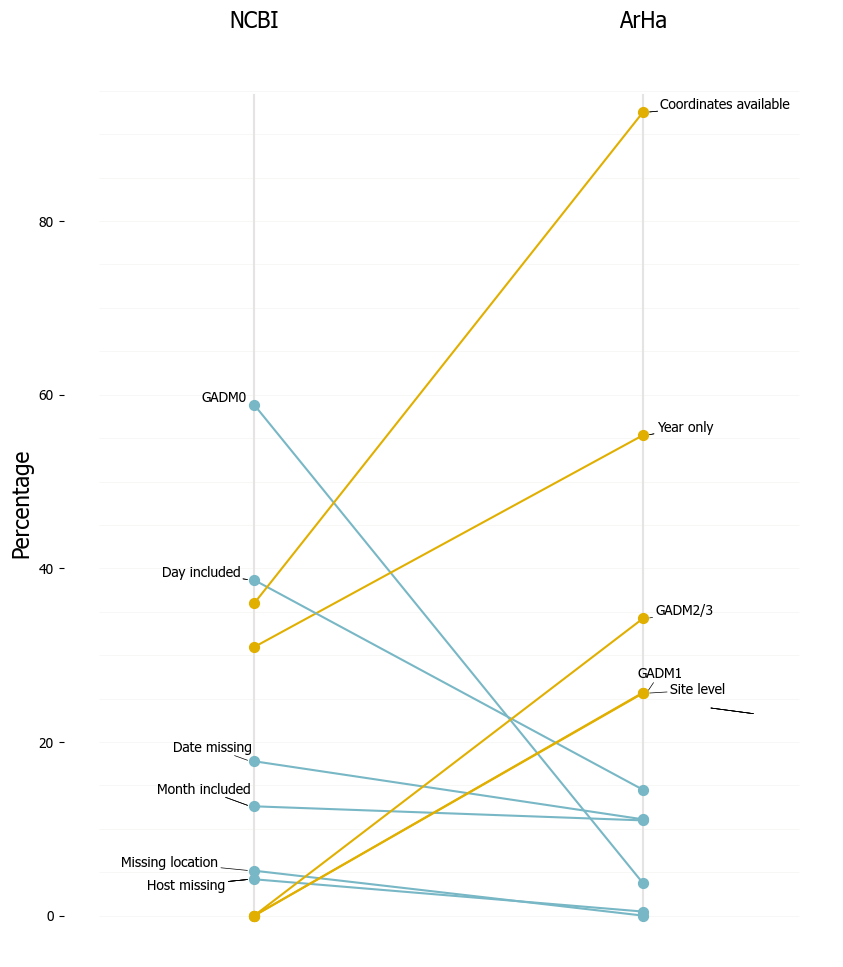

In [305]:
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text 

parallel_data = pd.DataFrame({
    'data': ['NCBI', 'ArHa'], 
    'NA': [round(percentage_na(viruses_ncbi), 3), round(percentage_na(enriched_arha), 3)],
    'Country': [round(percentage_country(viruses_ncbi), 3), round(percentage_country_arha(enriched_arha), 3)],
    'Collection_date_missing': [
        round(percentage_collection_date_missing(viruses_ncbi, 'collection_date'), 3), 
        round(percentage_collection_date_missing(enriched_arha, 'eventDate'), 3)
    ],
    'Collection_date_month': [
        round(percentage_collection_date_month(viruses_ncbi, 'collection_date'), 3), 
        round(percentage_collection_date_month(enriched_arha, 'eventDate'), 3)
    ],
    'Collection_date_year': [
        round(percentage_collection_date_year(viruses_ncbi, 'collection_date'), 3), 
        round(percentage_collection_date_year(enriched_arha, 'eventDate'), 3)
    ],
    'Collection_date_day': [
        round(percentage_collection_date_day(viruses_ncbi, 'collection_date'), 3), 
        round(percentage_collection_date_day(enriched_arha, 'eventDate'), 3)
    ],
    'percentage_coordinates': [
        round(percentage_coordinates_ncbi(viruses_ncbi), 3), 
        round(percentage_coordinates(enriched_arha, 'decimalLatitude', 'decimalLongitude'), 3)
    ],
    'missing_host': [
        round(missing_host(viruses_ncbi, 'species'), 3), 
        round(missing_host(enriched_arha, 'species'), 3)
    ],
    'percentage_city': [0, round(percentage_city_arha(enriched_arha), 3)],
    'percentage_state': [0, round(percentage_state_arha(enriched_arha), 3)],
    'percentage_site': [0, round(percentage_sampling_site_arha(enriched_arha), 3)]
})


# Define a dictionary for text formatting offsets and font sizes
label_dict = {
    "NA": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "Country": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "Number_NA": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "Number_country": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "Collection_date_missing": {"offset_left": 0.1, "offset_right": 0.05, "font_size": 10},
    "Collection_date_month": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "Collection_date_year": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "Collection_date_day": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "percentage_coordinates": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "missing_host": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "percentage_city": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10},
    "percentage_state": {"offset_left": -0.05, "offset_right": 0.1, "font_size": 10},
    "percentage_site": {"offset_left": -0.05, "offset_right": 0.05, "font_size": 10}
}

# Define label formatting dictionary
label_dict = {
    "NA": {"label": "Missing location", "ha_left": "right", "ha_right": "left"},
    "Country": {"label": "GADM0", "ha_left": "right", "ha_right": "left"},
    "Collection_date_year": {"label": "Year only", "ha_left": "right", "ha_right": "left"},
    "Collection_date_month": {"label": "Month included", "ha_left": "right", "ha_right": "left"},
    "Collection_date_day": {"label": "Day included", "ha_left": "right", "ha_right": "left"},
    "percentage_coordinates": {"label": "Coordinates available", "ha_left": "right", "ha_right": "left"},
    "missing_host": {"label": "Host missing", "ha_left": "right", "ha_right": "left"},
    "percentage_city": {"label": "GADM2/3", "ha_left": "right", "ha_right": "left"},
    "percentage_state": {"label": "GADM1", "ha_left": "right", "ha_right": "left"},
    "percentage_site": {"label": "Site level", "ha_left": "right", "ha_right": "left"},
    "Collection_date_missing": {"label": "Date missing", "ha_left": "right", "ha_right": "left"}
}

variables = [col for col in parallel_data.columns if col != 'data']
n_vars = len(variables)
base_left, base_right = 1.4, 2.4
x_left = [base_left for _ in range(n_vars)]
x_right = [base_right for _ in range(n_vars)]
c1 = '#78B7C5'
c2 = '#E1AF00'

fig, ax = plt.subplots(figsize=(11, 11))
fig.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.075)
ax.set_frame_on(False)
ax.hlines(np.arange(0, 100,5), 1, 2.8, alpha=0.4, lw=0.5, color='#E5E4E2', zorder=0)

TEXTS_left = []
TEXTS_right = []
for j, var in enumerate(variables):
    val_ncbi = parallel_data.loc[parallel_data["data"] == "NCBI", var].values[0]
    val_arha = parallel_data.loc[parallel_data["data"] == "ArHa", var].values[0]
    col = c1 if val_ncbi > val_arha else c2
    ax.plot([x_left[j], x_right[j]], [val_ncbi, val_arha], c=col, lw=1.5)
    ax.scatter(x_left[j], val_ncbi, c=col, s=50, zorder=10)
    ax.scatter(x_right[j], val_arha, c=col, s=50, zorder=10)
    if var in label_dict:
        if val_ncbi >= val_arha:
            left_text = ax.text(x_left[j] - 0.01, val_ncbi, label_dict[var]["label"],
                             size=10, ha=label_dict[var]["ha_left"], color='black')
        else:    
            right_text = ax.text(x_right[j] + 0.01, val_arha, label_dict[var]["label"],
                              size=10, ha=label_dict[var]["ha_right"], color='black')
        TEXTS_left.append(left_text)
        TEXTS_right.append(right_text)

for x_pos in [1.4, 2.4]:
    ax.axvline(x_pos, color='#E5E4E2', lw=1.5, zorder=0, ymin=0.05, ymax=0.95)

ax.text(1.4, 103, "NCBI",  size=16, ha='center', va='center', color='black')
ax.text(2.4, 103, "ArHa",  size=16, ha='center', va='center', color='black')

""" for var, props in label_dict.items():
    val_left = parallel_data.loc[parallel_data["data"]=="NCBI", var].values[0]
    ax.text(1.28, val_left, props["label"],  size=12, ha=props["ha_left"], va='center', color='black')
    val_right = parallel_data.loc[parallel_data["data"]=="ArHa", var].values[0]
    ax.text(2.32, val_right, props["label"],  size=12, ha=props["ha_right"], va='center', color='black')
 """
adjust_text(TEXTS_left, expand=(1.8, 1), expand_axes=True, avoid_self=True, time_lim=5,
            target_x=[1.2,1.4],
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            ax=ax)

adjust_text(TEXTS_right, expand=(1.8, 1), expand_axes=True, avoid_self=True, time_lim=5,
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            ax=ax)

ax.set_xticks([])
ax.set_ylabel("Percentage", size=16)
#plt.savefig('../output/genetic_data_parallel_plot.svg', format='svg', dpi=1200)
#plt.savefig('../output/genetic_data_parallel_plot.jpeg', format='jpeg', dpi=1200)
plt.show()